# References

### [sklearn]
- https://www.kaggle.com/mchirico/quick-look-seaborn-wordcloud
- https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

### [pytorch]
- https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from io import StringIO
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from text_processing import text_preprocessing
from wordcloud import WordCloud

# Data Preparation

- train-test split
- batch-loading
- data preparation for MIMIC from postgres
- null handling = sMOTE or other conventional methods
- auxilliary data for netflix needs to be collected

![](static/privacygan_titatic_preprocessing.png)

### Dataset 01: Titanic
- source: https://www.kaggle.com/c/titanic/data
- predict the survival based on passenger information

In [3]:
df_data = pd.read_csv('data/titanic.csv')
len_prev = len(df_data)
df_data.drop(['Cabin'], axis=1, inplace=True)
df_data.dropna(inplace=True)
len_curr = len(df_data)
print("{} rows with null values dropped".format(len_prev-len_curr))
print("{} rows of data available".format(len_curr))
df_data.head(3)

179 rows with null values dropped
712 rows of data available


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


### Text Preprocessing
- making text case insensitive
- handling special characters
- can possibly help match more columns in case of noisy data 
- standardize the categorical columns to prevent more dummy variables.

In [4]:
for col in ['Name', 'Sex', 'Embarked', 'Ticket']:
    df_data[col+'_preprocessed'] = list(map(text_preprocessing, df_data[col].tolist()))
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_preprocessed,Sex_preprocessed,Embarked_preprocessed,Ticket_preprocessed
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,braund mr owen harris,male,s,a 5 21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,cumings mrs john bradley florence briggs thayer,female,c,pc 17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,heikkinen miss laina,female,s,ston o2 3101282


### Visualizations

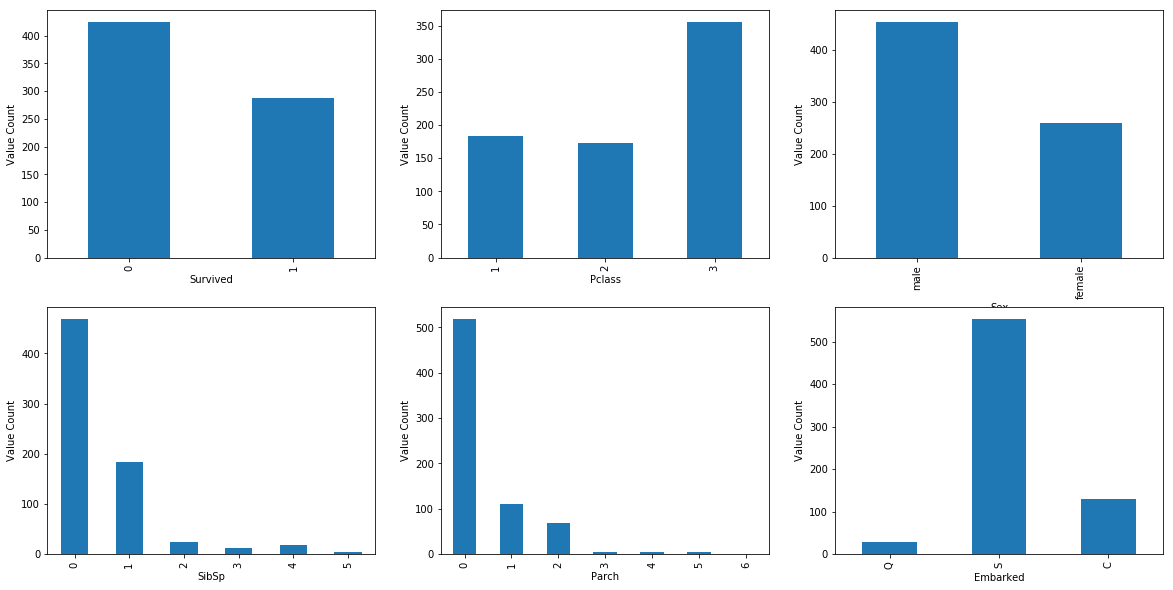

In [5]:
categorical_columns = [
    'Survived', 
    'Pclass', 
    'Sex', 
    'SibSp', 
    'Parch', 
    'Embarked'
]

num_cols = 3
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(categorical_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[categorical_columns[col]].value_counts(sort=False).plot(kind='bar')
    plt.xlabel(categorical_columns[col])
    plt.ylabel('Value Count')
plt.show()

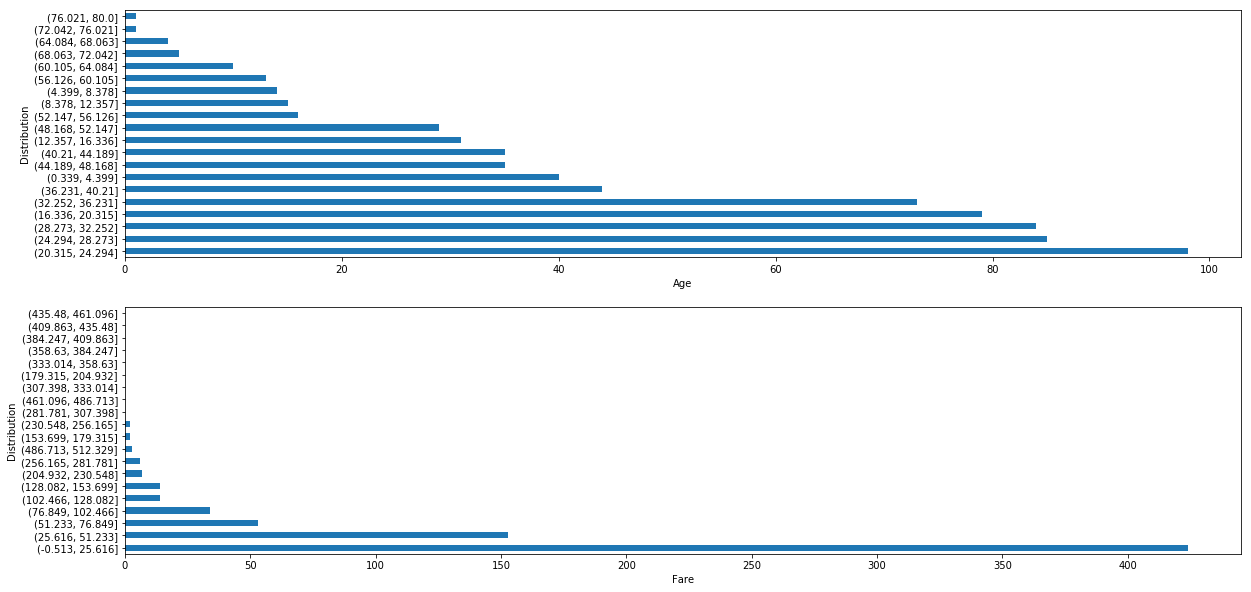

In [6]:
continuous_variables = [
    'Age', 
    'Fare'
]

num_cols = 1
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(continuous_variables)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[continuous_variables[col]].value_counts(bins=20, sort=True).plot(kind='barh')
    plt.xlabel(continuous_variables[col])
    plt.ylabel('Distribution')
plt.show()


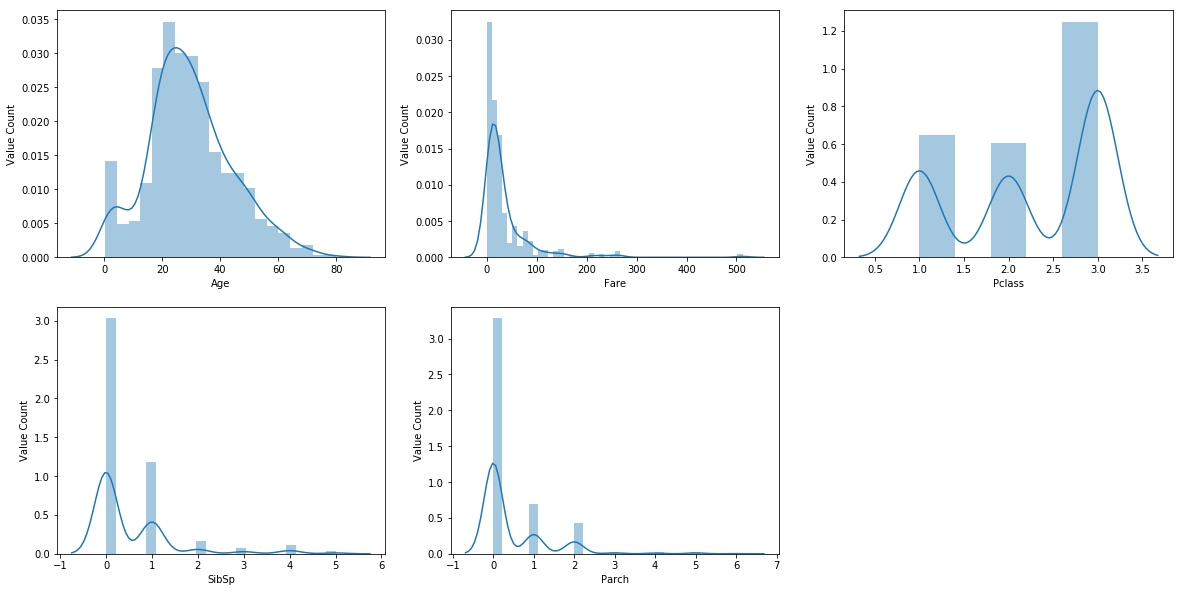

In [7]:
dist_columns = [
    'Age',
    'Fare',
    'Pclass',
    'SibSp',
    'Parch'
]

num_cols = 3
num_rows = math.ceil(len(dist_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(dist_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    sns.distplot(df_data[dist_columns[col]])
    plt.xlabel(dist_columns[col])
    plt.ylabel('Value Count')
plt.show()

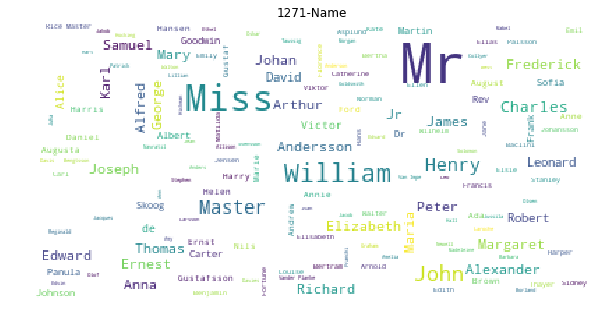

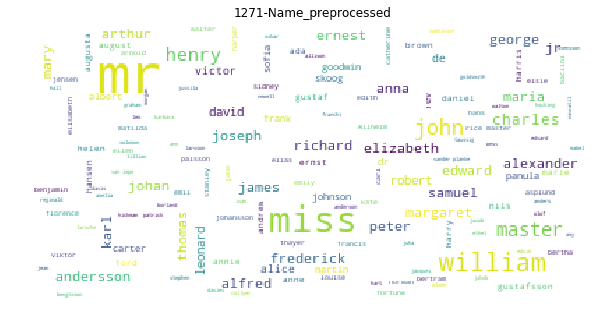

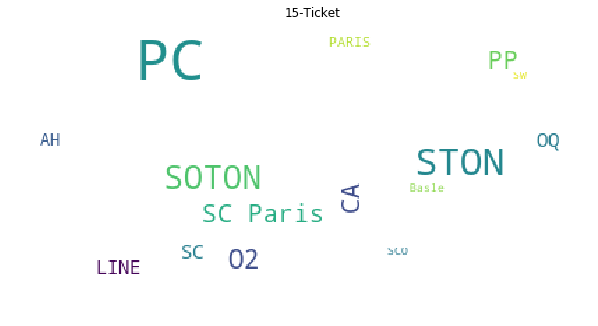

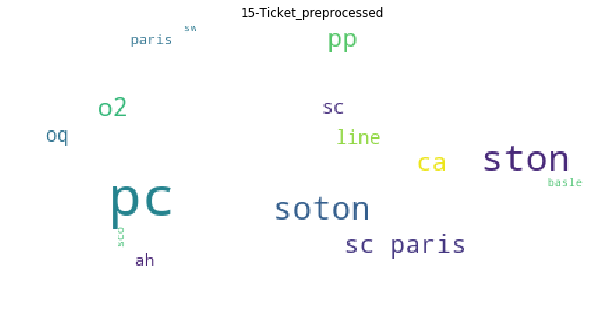

In [8]:
text_columns = ['Name', 'Name_preprocessed', 'Ticket', 'Ticket_preprocessed']

for col in range(len(text_columns)):
    si=StringIO()
    df_data[text_columns[col]].apply(lambda x: si.write(str(x) + " "))
    text=si.getvalue()
    si.close()

    wordcloud = WordCloud(width=1600, height=1600, max_words=100).generate(text)
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40, 
        relative_scaling=.5
    ).generate(text)
    plt.figure(figsize=(10, 20))
    plt.imshow(wordcloud)
    plt.title("{}-{}".format(str(len(wordcloud.words_)), text_columns[col]))
    plt.axis("off")
    plt.show()

### Definition of Ally and Adversary Variables.
- Ally target: Survived
- Adversary target: Sex
- The choice of adversary target can be changed.
- Chosen M/F here as it will be possible to have train-test split or k-fold validation

In [9]:
for col in ["Name", "Sex", "Embarked", "Ticket"]:
    df_data[col] = df_data[col+"_preprocessed"]
    df_data.drop([col+"_preprocessed"], axis=1, inplace=True)
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,braund mr owen harris,male,22.0,1,0,a 5 21171,7.2500,s
1,2,1,1,cumings mrs john bradley florence briggs thayer,female,38.0,1,0,pc 17599,71.2833,c
2,3,1,3,heikkinen miss laina,female,26.0,0,0,ston o2 3101282,7.9250,s


In [10]:
df_data = pd.get_dummies(df_data, columns=['Sex'], drop_first=True)
df_data = pd.get_dummies(df_data, columns=['Pclass', 'SibSp', 'Parch', 'Embarked'])
df_data.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Sex_male,Pclass_1,Pclass_2,Pclass_3,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,1,0,braund mr owen harris,22.0,a 5 21171,7.2500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2,1,cumings mrs john bradley florence briggs thayer,38.0,pc 17599,71.2833,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,heikkinen miss laina,26.0,ston o2 3101282,7.9250,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1,futrelle mrs jacques heath lily may peel,35.0,113803,53.1000,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,allen mr william henry,35.0,373450,8.0500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [11]:
y_ally = np.array(df_data.Survived.tolist())
y_advr = np.array(df_data.Sex_male.tolist())

df_data.drop(['Survived', 'Sex_male'], axis=1, inplace=True)

- using One hot encoding to convert the categorical data into dummy variables.
- Alternatively: [Managing categorical variables in pandas dataframe](http://benalexkeen.com/mapping-categorical-data-in-pandas/)
- Using count vectorizer to convert the text data into features based on bow model.

In [12]:
vectorizer = CountVectorizer()
Name = vectorizer.fit_transform(df_data.Name.tolist()).toarray()
vectorizer = CountVectorizer(vocabulary=wordcloud.words_.keys())
Ticket = vectorizer.fit_transform(df_data.Ticket.tolist()).toarray()

In [13]:
df_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df_data.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,22.0,7.2500,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [14]:
X = np.concatenate((df_data.values, Name, Ticket), axis=1)
y_ally.shape, y_advr.shape, X.shape

((712,), (712,), (712, 1324))

# Checkpoint

In [15]:
import pickle as pkl

pkl.dump((X, y_ally, y_advr), open('checkpoints/titanic_processed_data_X_y_ally_y_advr.pkl', 'wb'))

In [ ]:
import pickle as pkl

X, y_ally, y_advr = pkl.load(open('checkpoints/mimic_processed_data_X_y_ally_y_advr.pkl', 'rb'))

### Train Test Split

- This step is required before the Scaling or PCA is learnt on the train dataset and then used to transform the test dataset.

In [16]:
X_train, X_valid, y_ally_train, y_ally_valid, y_advr_train, y_advr_valid = train_test_split(
    X, 
    y_ally,
    y_advr,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_train.shape, y_advr_valid.shape

((640, 1324), (72, 1324), (640,), (72,), (640,), (72,))

### Checking the distribution after the split

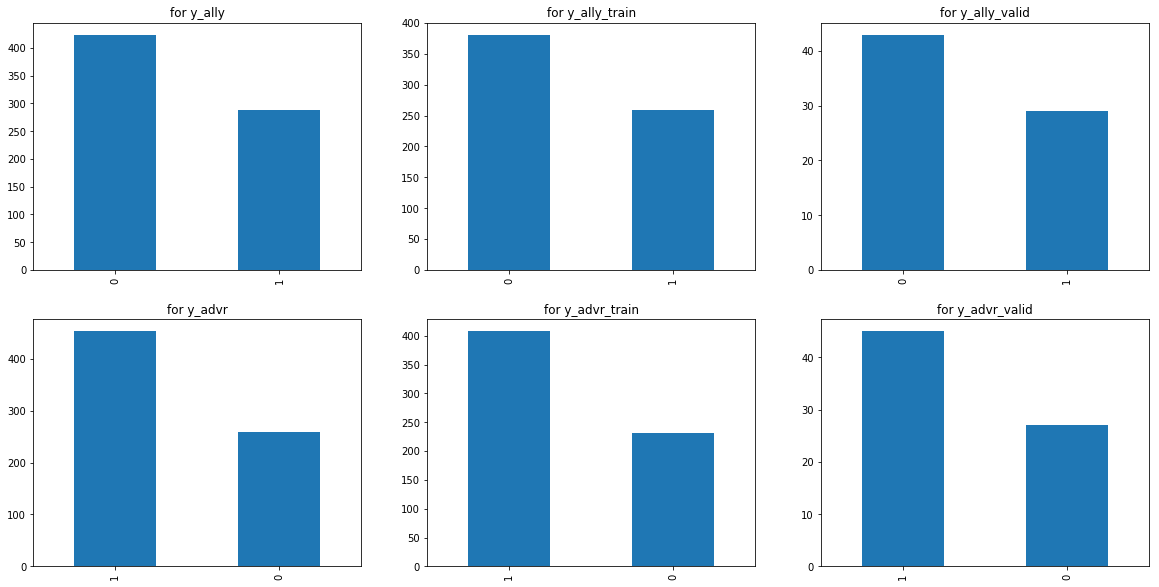

In [17]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(2, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(2, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(2, 3, 4)
pd.value_counts(y_advr).plot(kind='bar')
plt.title('for y_advr')
plt.subplot(2, 3, 5)
pd.value_counts(y_advr_train).plot(kind='bar')
plt.title('for y_advr_train')
plt.subplot(2, 3, 6)
pd.value_counts(y_advr_valid).plot(kind='bar')
plt.title('for y_advr_valid')
plt.show()

### Scaler
- Perform minmax scaling for removing the skewness which might effect the gradient descent during neural network training. 
- It is necessary to do this scaling before PCA is applied

In [18]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

![](static/privacygan_titanic_experiment.png)

### Apply PCA and select components using explained variances

In [19]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

In [20]:
num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9900532700330905 588


In [21]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((640, 588), (72, 588))

### Apply Auto-encoder for dimensionality reduction

![](static/privacygan_titanic_autoencoder.png)

In [22]:
import torch
import torch.utils.data as utils
import torch.nn as nn

In [23]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

X_train_torch = torch.Tensor(X_train_normalized).to(device)
X_valid_torch = torch.Tensor(X_valid_normalized).to(device)
y_ally_train_torch = torch.Tensor(y_ally_train.reshape(-1, 1)).to(device)
y_ally_valid_torch = torch.Tensor(y_ally_valid.reshape(-1, 1)).to(device)
y_advr_train_torch = torch.Tensor(y_advr_train.reshape(-1, 1)).to(device)
y_advr_valid_torch = torch.Tensor(y_advr_valid.reshape(-1, 1)).to(device)

DType: torch.float32
Cuda available: True
Device: cuda


In [24]:
X_train_torch.shape, X_valid_torch.shape, \
y_ally_train_torch.shape, y_ally_valid_torch.shape, \
y_advr_train_torch.shape, y_advr_valid_torch.shape

(torch.Size([640, 1324]),
 torch.Size([72, 1324]),
 torch.Size([640, 1]),
 torch.Size([72, 1]),
 torch.Size([640, 1]),
 torch.Size([72, 1]))

In [25]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [26]:
auto_encoder = AutoEncoder(input_size=X_train.shape[1],encoding_dim=X_train_reduced.shape[1]).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.001)

In [27]:
print("epoch \t Aencoder_train \t Aencoder_valid")

ae_epoch = []
ae_train = []
ae_valid = []

for epoch in range(201):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_train_torch_hat = auto_encoder(X_train_torch)
    ae_loss = criterion(X_train_torch_hat, X_train_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    if epoch%20!=0:
        continue
        
    auto_encoder.eval()
    
    X_valid_torch_hat = auto_encoder(X_valid_torch)
    ae_valid_loss = criterion(X_valid_torch_hat, X_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss
    ))
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_valid_loss)

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 1.17781365 	 0.69305533
20 	 0.88391012 	 0.44267642
40 	 0.84786075 	 0.42286864
60 	 0.83982235 	 0.41530463
80 	 0.83549732 	 0.41119158
100 	 0.83372903 	 0.40932369
120 	 0.83310246 	 0.40843549
140 	 0.83283329 	 0.40789393
160 	 0.83262753 	 0.40750381
180 	 0.83251673 	 0.40720659
200 	 0.83244413 	 0.40696481


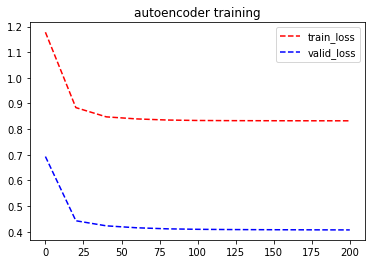

In [28]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss', 'valid_loss'])
plt.title("autoencoder training")
plt.show()

In [29]:
auto_encoder.eval()
X_train_torch_ae = auto_encoder.encoder(X_train_torch)
X_valid_torch_ae = auto_encoder.encoder(X_valid_torch)
X_train_torch_ae.shape, X_valid_torch_ae.shape

(torch.Size([640, 588]), torch.Size([72, 588]))

# GAN using Pytorch

- ["**Learning Informative and Private Representations via Generative Adversarial Networks**"](http://www.princeton.edu/~pmittal/publications/gan-bigdata18.pdf)

![](static/privacygan_titanic_privacygan.png)

### GAN V1

```python
encd_N = 64 
encd_D_in = X.shape[1]
encd_H = int(encd_D_in/2)
encd_D_out = 64

# encoder
encd_w1 = torch.randn(encd_D_in, encd_H, device=device, dtype=dtype, requires_grad=True)
encd_w2 = torch.randn(encd_H, encd_D_out, device=device, dtype=dtype, requires_grad=True)

ally_N = 64 
ally_D_in = encd_D_out
ally_H = int(ally_D_in/2)
ally_D_out = 1

# ally
ally_w1 = torch.randn(ally_D_in, ally_H, device=device, dtype=dtype, requires_grad=True)
ally_w2 = torch.randn(ally_H, ally_D_out, device=device, dtype=dtype, requires_grad=True)

advr_N = 64 
advr_D_in = encd_D_out
advr_H = int(advr_D_in/2)
advr_D_out = 2

# advr
advr_w1 = torch.randn(advr_D_in, advr_H, device=device, dtype=dtype, requires_grad=True)
advr_w2 = torch.randn(advr_H, advr_D_out, device=device, dtype=dtype, requires_grad=True)
```

### GAN V2

In [30]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [31]:
def train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True):
    encoding_dimension = X_train_reduced.shape[1]
    encoder = Encoder(input_size=X_train_torch.shape[1], hidden_size=1024, output_size=encoding_dimension).cuda()
    ally = Ally(input_size=encoding_dimension, hidden_size=128, output_size=y_ally_train_torch.shape[1]).cuda()
    adversary = Adversary(input_size=encoding_dimension, hidden_size=128, output_size=y_advr_train_torch.shape[1]).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    encd_optimizer = optimizer(encoder.parameters(), lr = lr_encd)
    ally_optimizer = optimizer(ally.parameters(), lr=lr_ally)
    advr_optimizer = optimizer(adversary.parameters(), lr=lr_advr)

    if debug:
        print("epoch \t encoder_train \t encoder_valid \t ally_train \t ally_valid \t advr_train \t advr_valid")

    g_epoch = []
    enc_train = []
    enc_valid = []
    ally_train = []
    ally_valid = []
    advr_train = []
    advr_valid = []

    for epoch in range(n_iter_gan):
        # set for training
        encoder.train()
        ally.train()
        adversary.train()

        encd_optimizer.zero_grad()
        # Forward passv
        X_train_encoding = encoder(X_train_torch)
        y_ally_train_torch_hat = ally(X_train_encoding)
        y_advr_train_torch_hat = adversary(X_train_encoding)
        # Compute Loss
        ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
        # Backward pass
        encd_loss.backward(retain_graph=True)
        encd_optimizer.step()

        for i in range(d_reps):
            ally_optimizer.zero_grad()
            advr_optimizer.zero_grad()

            X_train_encoding = encoder(X_train_torch)
            y_ally_train_torch_hat = ally(X_train_encoding)
            y_advr_train_torch_hat = adversary(X_train_encoding)

            ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
            advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)

            ally_loss.backward(retain_graph=True)
            advr_loss.backward(retain_graph=True)

            ally_optimizer.step()
            advr_optimizer.step()

        if epoch%20!=0 and (debug or plot):
            continue

        # set for eval
        encoder.eval()
        ally.eval()
        adversary.eval()

        X_valid_encoding = encoder(X_valid_torch)
        y_ally_valid_torch_hat = ally(X_valid_encoding)
        y_advr_valid_torch_hat = adversary(X_valid_encoding)

        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
        encd_valid_loss = alpha * ally_loss - ((1-alpha) * advr_loss)

        if debug:
            print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
                epoch, 
                encd_loss.item(),
                encd_valid_loss,
                ally_loss.item(), 
                ally_valid_loss,
                advr_loss.item(),
                advr_valid_loss,
            ))

        if plot:
            g_epoch.append(epoch)
            enc_train.append(encd_loss.item())
            enc_valid.append(encd_valid_loss.item())
            ally_train.append(ally_loss.item())
            ally_valid.append(ally_valid_loss.item())
            advr_train.append(advr_loss.item())
            advr_valid.append(advr_valid_loss.item())
    if plot:
        plt.plot(g_epoch, enc_train, 'r')
        plt.plot(g_epoch, enc_valid, 'r--')
        plt.plot(g_epoch, ally_train, 'b')
        plt.plot(g_epoch, ally_valid, 'b--')
        plt.plot(g_epoch, advr_train, 'g')
        plt.plot(g_epoch, advr_valid, 'g--')
        plt.legend([
            'encoder train loss', 
            'encoder valid loss',
            'ally train loss',
            'ally valid loss',
            'advr train loss',
            'advr valid loss'
        ])
        plt.title("GAN training")
        plt.show()
    
    return encoder  

epoch 	 encoder_train 	 encoder_valid 	 ally_train 	 ally_valid 	 advr_train 	 advr_valid
0 	 0.06114006 	 0.06038547 	 0.77638239 	 0.77385277 	 0.65561146 	 0.66157556
20 	 0.02672905 	 0.02616131 	 0.71470386 	 0.71888238 	 0.66238123 	 0.66353822
40 	 0.00871512 	 0.00778797 	 0.69697189 	 0.70331079 	 0.68139595 	 0.66797513
60 	 -0.01097772 	 -0.01225987 	 0.69075638 	 0.69936734 	 0.71527612 	 0.67556381
80 	 -0.03436437 	 -0.03562245 	 0.67622519 	 0.69862962 	 0.74747008 	 0.68471253
100 	 -0.06203878 	 -0.06298640 	 0.63453335 	 0.69923663 	 0.76050615 	 0.69159603
120 	 -0.07639802 	 -0.07684395 	 0.60274762 	 0.69238549 	 0.75643551 	 0.69328290
140 	 -0.08014771 	 -0.08042961 	 0.59320682 	 0.69390118 	 0.75406605 	 0.69345123


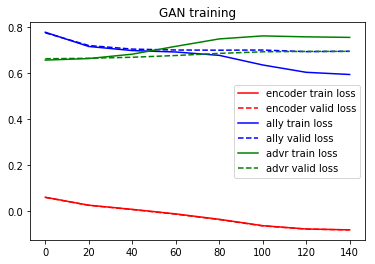

In [32]:
alpha = 0.5
lr_encd = 0.0001
lr_ally = 0.0001
lr_advr = 0.00001
n_iter_gan = 151
d_reps = 1

# alpha = 0.5
# lr_encd = 0.0001
# lr_ally = 0.0001
# lr_advr = 0.00001
# n_iter_gan = 151
# d_reps = 1


encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

# Ally and Adversary Learning on Encoded Data

In [33]:
X_train_encoded = encoder(X_train_torch)
X_valid_encoded = encoder(X_valid_torch)
X_train_encoded.shape, X_valid_encoded.shape

(torch.Size([640, 588]), torch.Size([72, 588]))

In [34]:
X_train_reduced.shape, X_valid_reduced.shape

((640, 588), (72, 588))

In [35]:
y_ally_train_torch.shape, y_ally_valid_torch.shape

(torch.Size([640, 1]), torch.Size([72, 1]))

In [36]:
class Network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [37]:
def train_ally(lr, n_epochs, debug=True):
    network = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network.parameters(), lr=lr)    

    if debug:
        print("epoch \t ally_train \t ally_valid")

    n_epoch = []
    train = []
    valid = []
    for epoch in range(501):
        network.train()
        net_optimizer.zero_grad()

        y_ally_train_torch_hat = network(X_train_encoded)
        loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%(int(n_epochs/10))!=0:
            continue

        # set for eval
        network.eval()
        y_ally_valid_torch_hat = network(X_valid_encoded)
        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)

        if debug:
            print('{} \t {:.8f} \t {:.8f}'.format(
                epoch,  
                loss.item(),
                ally_valid_loss.item()
            ))

        n_epoch.append(epoch)
        train.append(loss.item())
        valid.append(ally_valid_loss.item())
    return n_epoch, train, valid

In [38]:
lr = 0.0001
n_epochs = 501

n_epoch, gan_train_ally, gan_valid_ally = train_ally(lr, n_epochs)

epoch 	 ally_train 	 ally_valid
0 	 0.79211539 	 0.79167926
50 	 0.66791338 	 0.72221726
100 	 0.63420266 	 0.70916420
150 	 0.61992866 	 0.70327151
200 	 0.61135238 	 0.70020473
250 	 0.60553330 	 0.69834191
300 	 0.60137773 	 0.69711143
350 	 0.59831423 	 0.69624913
400 	 0.59599745 	 0.69561923
450 	 0.59420615 	 0.69514626
500 	 0.59279317 	 0.69478524


In [39]:
def train_advr(lr, n_epochs, debug=True):
    network_advr = Network(X_train_reduced.shape[1], 128, 1).cuda()
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

    if debug:
        print("epoch \t advr_train \t advr_valid")

    train_a = []
    valid_a = []

    for epoch in range(n_epochs):
        network_advr.train()
        net_optimizer.zero_grad()

        y_advr_train_torch_hat = network_advr(X_train_encoded)
        loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%(int(n_epochs/10))!=0:
            continue

        # set for eval
        network_advr.eval()
        y_advr_valid_torch_hat = network_advr(X_valid_encoded)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)

        if debug:
            print('{} \t {:.8f} \t {:.8f}'.format(
                epoch,  
                loss.item(),
                advr_valid_loss.item()
            ))
        train_a.append(loss.item())
        valid_a.append(advr_valid_loss.item())
    return train_a, valid_a

In [40]:
lr = 0.001
n_epochs = 501

gan_train_advr, gan_valid_advr = train_advr(lr, n_epochs)

epoch 	 advr_train 	 advr_valid
0 	 0.65202045 	 0.65280163
50 	 0.46060443 	 0.59517831
100 	 0.45848694 	 0.59484857
150 	 0.45784855 	 0.59500861
200 	 0.45754376 	 0.59525734
250 	 0.45737156 	 0.59549743
300 	 0.45726356 	 0.59571058
350 	 0.45719081 	 0.59589612
400 	 0.45713910 	 0.59605736
450 	 0.45710096 	 0.59619808
500 	 0.45707184 	 0.59632176


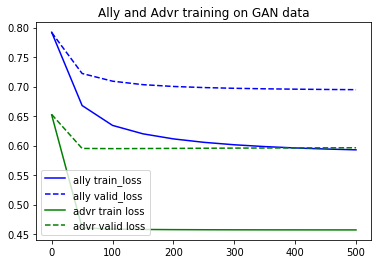

In [41]:
plt.plot(n_epoch, gan_train_ally, 'b')
plt.plot(n_epoch, gan_valid_ally, 'b--')
plt.plot(n_epoch, gan_train_advr, 'g')
plt.plot(n_epoch, gan_valid_advr, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on GAN data")
plt.show()

# Variations over Alpha

In [43]:
alphas = [0, 0.25, 0.5, 0.75, 1]

Comparison


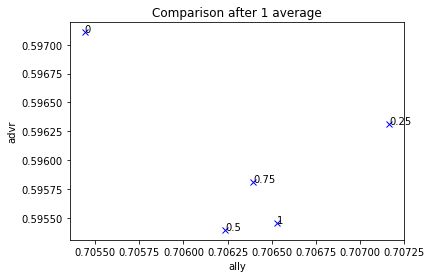

Comparison


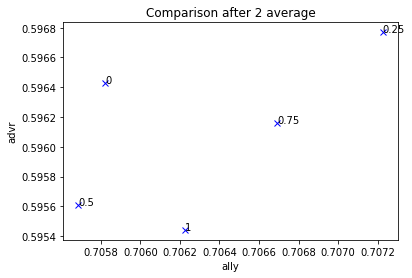

Comparison


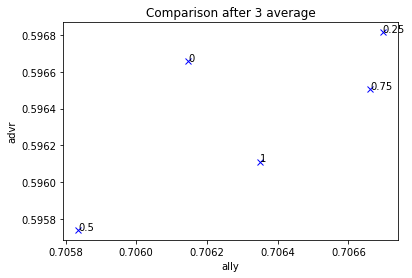

Comparison


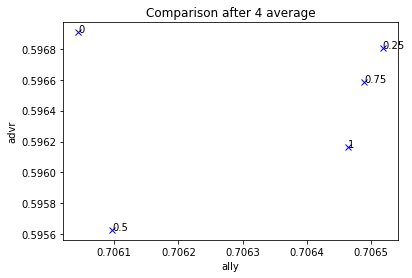

Comparison


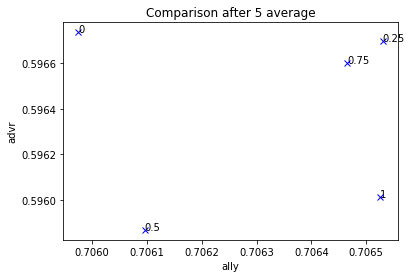

Comparison


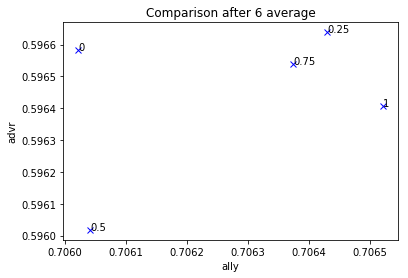

Comparison


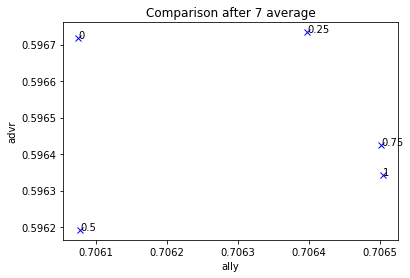

Comparison


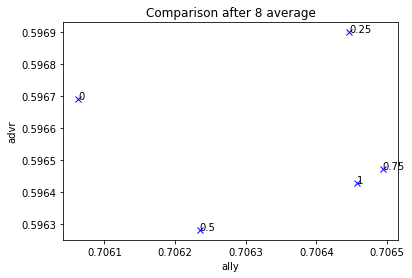

Comparison


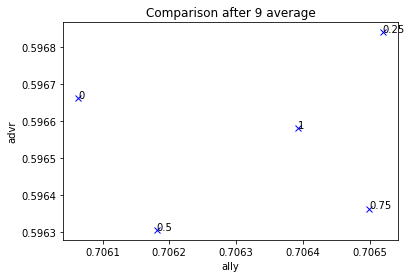

Comparison


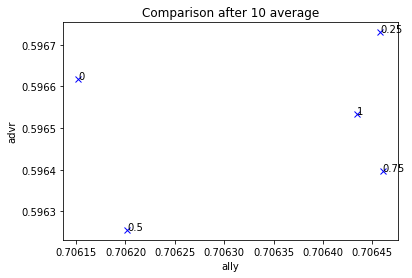

In [44]:
gan_ally_over_alpha = [0, 0, 0, 0, 0]
gan_advr_over_alpha = [0, 0, 0, 0, 0]
average_over = 10
for i in range(average_over):
    for idx, alpha in enumerate(alphas):
#         print("="*80)
#         print(alpha)
#         print("="*80)
        encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=False, debug=False)
        n_epoch, gan_train_ally, gan_valid_ally = train_ally(lr, n_epochs, debug=False)
        gan_train_advr, gan_valid_advr = train_advr(lr, n_epochs, False)
        gan_ally_over_alpha[idx] = i * gan_ally_over_alpha[idx] + gan_valid_ally[-1]
        gan_advr_over_alpha[idx] = i * gan_advr_over_alpha[idx] + gan_valid_advr[-1]
#         plt.plot(n_epoch, gan_train_ally, 'b')
#         plt.plot(n_epoch, gan_valid_ally, 'b--')
#         plt.plot(n_epoch, gan_train_advr, 'g')
#         plt.plot(n_epoch, gan_valid_advr, 'g--')
#         plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
#         plt.title("Ally and Advr training on GAN data")
#         plt.show()
    gan_ally_over_alpha = [_/(i+1) for _ in gan_ally_over_alpha]
    gan_advr_over_alpha = [_/(i+1) for _ in gan_advr_over_alpha]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    print("="*80)
    print("Comparison")
    print("="*80)
    plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
    plt.xlabel('ally')
    plt.ylabel('advr')
    plt.title('Comparison after {} average'.format(i+1))
    for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
        ax.annotate('%s' % label, xy=xy, textcoords='data')
    plt.show()

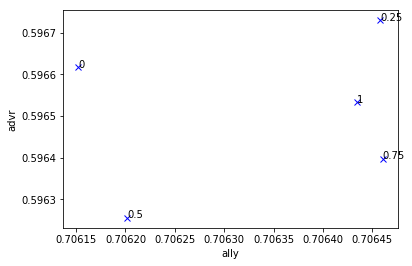

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
plt.xlabel('ally')
plt.ylabel('advr')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')

# Ally and Adversary Learning on DP Data

In [46]:
def laplaceMechanism(x, epsilon):
    x +=  torch.Tensor(np.random.laplace(0, 1.0/epsilon, x.shape)).cuda()
    return x

In [47]:
epsilon = 0.1

In [48]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

lr = 0.0001

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

dp_ally_train = []
dp_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    
    y_ally_train_torch_hat = network_ally_pca(X_train_iter)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    dp_ally_train.append(loss.item())
    dp_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.76153225 	 0.76201969
50 	 0.73312277 	 0.74593800
100 	 0.71232545 	 0.73416710
150 	 0.69922632 	 0.72677451
200 	 0.69081134 	 0.72201931
250 	 0.68350679 	 0.71900147
300 	 0.67427820 	 0.71736187
350 	 0.66636604 	 0.71684712
400 	 0.65928566 	 0.71700257
450 	 0.65180093 	 0.71754986
500 	 0.64315623 	 0.71851850


In [49]:
lr = 0.001

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

dp_advr_train = []
dp_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    y_advr_train_torch_hat = network_advr_pca(X_train_iter)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    dp_advr_train.append(loss.item())
    dp_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.65956610 	 0.66343349
50 	 0.55531204 	 0.66148400
100 	 0.49489203 	 0.66162050
150 	 0.47345647 	 0.66298914
200 	 0.46379891 	 0.66321224
250 	 0.45919332 	 0.66288602
300 	 0.45719153 	 0.66231501
350 	 0.45570832 	 0.66097671
400 	 0.45477280 	 0.66099656
450 	 0.45409346 	 0.66119564
500 	 0.45361501 	 0.66126209


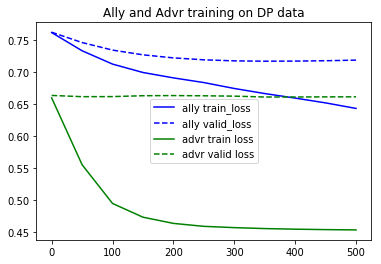

In [50]:
plt.plot(n_epoch, dp_ally_train, 'b')
plt.plot(n_epoch, dp_ally_valid, 'b--')
plt.plot(n_epoch, dp_advr_train, 'g')
plt.plot(n_epoch, dp_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on DP data")
plt.show()

In [51]:
epsilons = [1, 26, 51, 71, 101,]

1 0.543443500995636 0.7128424644470215
1 0.4519207179546356 0.6664050221443176


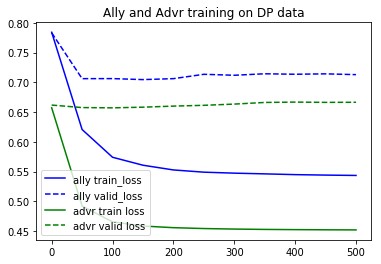

26 0.5451564788818359 0.7252059578895569
26 0.453634649515152 0.5396084189414978


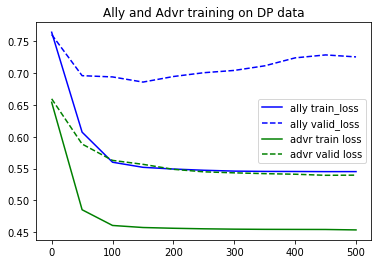

51 0.5448790788650513 0.6878031492233276
51 0.4566505551338196 0.5122409462928772


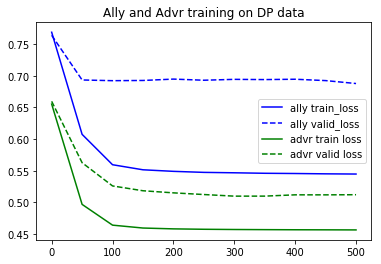

71 0.5459921956062317 0.7059594392776489
71 0.45685502886772156 0.5145440697669983


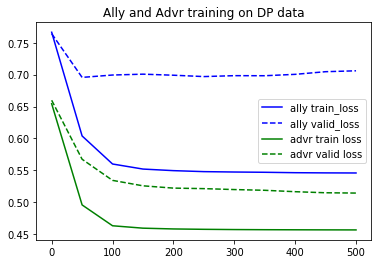

101 0.545886218547821 0.6883905529975891
101 0.4602126181125641 0.4957483112812042


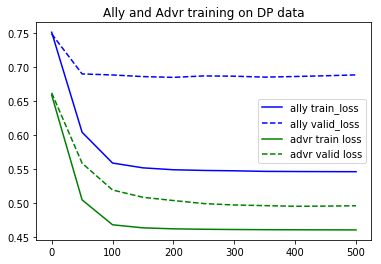

In [52]:
ally_dp_over_epsilons = []
advr_dp_over_epsilons = []
for epsilon in epsilons:
    X_train_pca_torch = torch.Tensor(X_train_reduced)
    X_valid_pca_torch = torch.Tensor(X_valid_reduced)

    lr = 0.001

    network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

    dp_ally_train = []
    dp_ally_valid = []

    X_train_pca_torch = X_train_pca_torch.to(device)
    X_valid_pca_torch = X_valid_pca_torch.to(device)
    y_ally_train_torch = y_ally_train_torch.to(device)
    y_ally_valid_torch = y_ally_valid_torch.to(device)

    for epoch in range(501):
        network_ally_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)

        y_ally_train_torch_hat = network_ally_pca(X_train_iter)
        loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%50!=0:
            continue

        # set for eval
        network_ally_pca.eval()
        y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)

        dp_ally_train.append(loss.item())
        dp_ally_valid.append(ally_valid_loss)

    ally_dp_over_epsilons.append(ally_valid_loss.item())
    print(epsilon, loss.item(), ally_valid_loss.item())

    lr = 0.001

    network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

    y_advr_train_torch = y_advr_train_torch.to(device)
    y_advr_valid_torch = y_advr_valid_torch.to(device)

    dp_advr_train = []
    dp_advr_valid = []

    for epoch in range(501):
        network_advr_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
        y_advr_train_torch_hat = network_advr_pca(X_train_iter)
        loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%50!=0:
            continue

        # set for eval
        network_advr_pca.eval()
        y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)

        dp_advr_train.append(loss.item())
        dp_advr_valid.append(advr_valid_loss)

    print(epsilon, loss.item(), advr_valid_loss.item())
    advr_dp_over_epsilons.append(advr_valid_loss.item())
    
    plt.plot(n_epoch, dp_ally_train, 'b')
    plt.plot(n_epoch, dp_ally_valid, 'b--')
    plt.plot(n_epoch, dp_advr_train, 'g')
    plt.plot(n_epoch, dp_advr_valid, 'g--')
    plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
    plt.title("Ally and Advr training on DP data")
    plt.show()

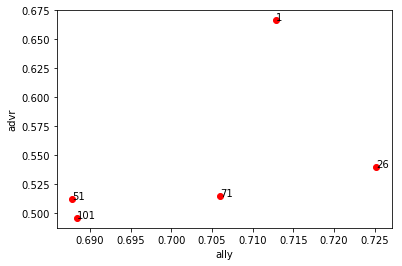

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.xlabel('ally')
plt.ylabel('advr')

for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')

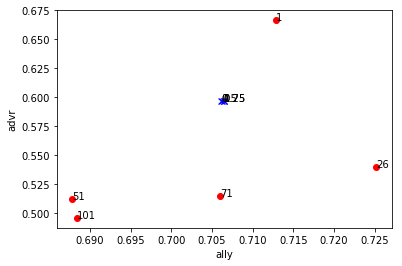

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
plt.xlabel('ally')
plt.ylabel('advr')
plt.show()

# Ally and Adversary Learning on PCA Data

In [55]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

In [56]:
lr = 0.01

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

pca_ally_train = []
pca_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_pca(X_train_pca_torch)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    pca_ally_train.append(loss.item())
    pca_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.76872218 	 0.73135591
50 	 0.54683012 	 0.70494348
100 	 0.54666245 	 0.69649833
150 	 0.54662091 	 0.69334346
200 	 0.54659796 	 0.69162679
250 	 0.54658359 	 0.69049585
300 	 0.54657286 	 0.68971729
350 	 0.54598230 	 0.68937325
400 	 0.54596978 	 0.68866742
450 	 0.54596514 	 0.68805856
500 	 0.54596174 	 0.68764573


In [57]:
lr = 0.001

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

pca_advr_train = []
pca_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_pca(X_train_pca_torch)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    pca_advr_train.append(loss.item())
    pca_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.65540773 	 0.66105175
50 	 0.49792638 	 0.55337363
100 	 0.46530372 	 0.52152169
150 	 0.46150786 	 0.51256371
200 	 0.46032724 	 0.50867164
250 	 0.45976850 	 0.50630677
300 	 0.45944110 	 0.50470054
350 	 0.45888177 	 0.50351775
400 	 0.45819637 	 0.50186741
450 	 0.45807076 	 0.50125933
500 	 0.45798874 	 0.50080872


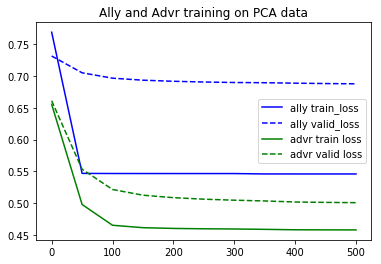

In [58]:
plt.plot(n_epoch, pca_ally_train, 'b')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_train, 'g')
plt.plot(n_epoch, pca_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on PCA data")
plt.show()

# Ally and Adversary Training on Auto-encoded data

In [59]:
lr = 0.001

network_ally_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_ae.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

ae_ally_train=[]
ae_ally_valid = []

for epoch in range(501):
    network_ally_ae.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_ae(X_train_torch_ae)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_ae.eval()
    y_ally_valid_torch_hat = network_ally_ae(X_valid_torch_ae)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    ae_ally_train.append(loss.item())
    ae_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.77883023 	 0.75360572
50 	 0.69454062 	 0.69472450
100 	 0.69310874 	 0.69360816
150 	 0.67415690 	 0.68475765
200 	 0.57774013 	 0.66538268
250 	 0.56610692 	 0.66449773
300 	 0.56270844 	 0.67120630
350 	 0.56117553 	 0.67483222
400 	 0.56061757 	 0.67561096
450 	 0.55925339 	 0.67532796
500 	 0.55830759 	 0.67543221


In [60]:
lr = 0.001

network_advr_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_ae.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

ae_advr_train = []
ae_advr_valid = []

for epoch in range(501):
    network_advr_ae.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_ae(X_train_torch_ae)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_ae.eval()
    y_advr_valid_torch_hat = network_advr_ae(X_valid_torch_ae)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    ae_advr_train.append(loss.item())
    ae_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.65537840 	 0.65414250
50 	 0.45905596 	 0.54126674
100 	 0.45337340 	 0.53520954
150 	 0.45229444 	 0.53339714
200 	 0.45183602 	 0.53242326
250 	 0.45159015 	 0.53179544
300 	 0.45144054 	 0.53134865
350 	 0.45134172 	 0.53100997
400 	 0.45127255 	 0.53074145
450 	 0.45122194 	 0.53052104
500 	 0.45118362 	 0.53033566


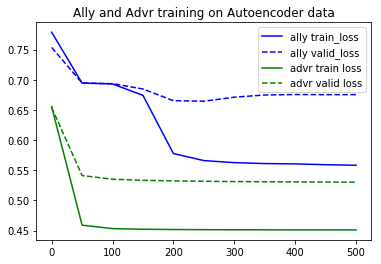

In [61]:
plt.plot(n_epoch, ae_ally_train, 'b')
plt.plot(n_epoch, ae_ally_valid, 'b--')
plt.plot(n_epoch, ae_advr_train, 'g')
plt.plot(n_epoch, ae_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

# Results

| Model | Train Ally  | Valid Ally  | Train Advr | Valid Advr |
|---|---:|---:|---:|---:|
| PCA | 0.54596204 | **0.63508838** | 0.45774460 | 0.47422782 |
| A-Enc | 0.69294691 | 0.69324082 | 0.45286497 | 0.50768989 |
| P-GAN | 0.53968185 | 0.69574529 | 0.45563743 | **0.59513420** |

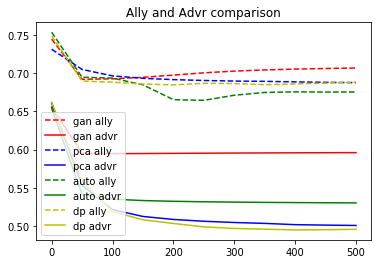

In [62]:
plt.plot(n_epoch, gan_valid_ally, 'r--')
plt.plot(n_epoch, gan_valid_advr, 'r')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_valid, 'b')
plt.plot(n_epoch, ae_ally_valid, 'g--')
plt.plot(n_epoch, ae_advr_valid, 'g')
plt.plot(n_epoch, dp_ally_valid, 'y--')
plt.plot(n_epoch, dp_advr_valid, 'y')
plt.legend(['gan ally', 'gan advr', 'pca ally', 'pca advr', 'auto ally', 'auto advr', 'dp ally', 'dp advr'])
plt.title("Ally and Advr comparison")
plt.show()

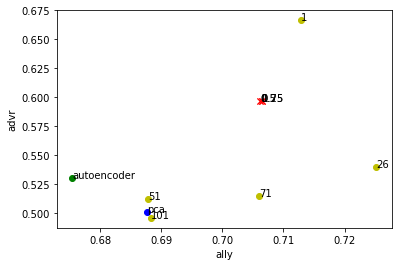

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'yo')
plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'rx')
for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
plt.plot([pca_ally_valid[-1]], [pca_advr_valid[-1]], 'bo')
ax.annotate('%s' % 'pca', xy=(pca_ally_valid[-1], pca_advr_valid[-1]), textcoords='data')
plt.plot([ae_ally_valid[-1]], [ae_advr_valid[-1]], 'go')
ax.annotate('%s' % 'autoencoder', xy=(ae_ally_valid[-1], ae_advr_valid[-1]), textcoords='data')
plt.xlabel('ally')
plt.ylabel('advr')
plt.show()